In [46]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
import tensorflow as tf
# Importation du jeu de données
import pathlib
import os

In [47]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#  On load le data set

In [48]:
data_dir = pathlib.Path('data/anime_images')
print(data_dir)
print(os.path.abspath(data_dir))

data/anime_images
/home/depinfo/Bureau/Projet-IA-1/data/anime_images


In [49]:
# Comptage du nombre d'images
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

83067


# On crée les 2 "axes" X=les images y=leurs labels

In [50]:
# Paramètres pour la création des ensembles de données
batch_size = 3
img_height = 200
img_width = 200

# Création des ensembles de données d'entraînement et de validation
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Noms de classe
class_names = val_data.class_names
print(len(class_names))

Found 83066 files belonging to 232 classes.
Using 66453 files for training.
Found 83066 files belonging to 232 classes.
Using 16613 files for validation.
232


2024-05-16 18:30:34.042106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


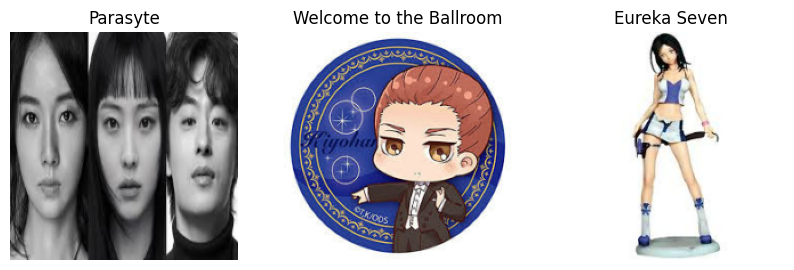

In [51]:
# Affichage des images d'exemple
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

 # initialisaton du model

In [52]:
import tensorflow as tf

# Définition du modèle CNN
num_classes = 231  # nombre de classes
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Sauvegarde des poids du modèle après l'entraînement
model.save_weights('poids_modele_cnn.weights.h5')

# Définition de l'architecture du modèle à recharger
model_reloaded = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

try:
    # Essayez de charger le modèle complet (architecture + poids)
    model_reloaded = tf.keras.models.load_model('model_weights.h5')
except (OSError, IOError) as e:
    print(f"Le chargement du modèle complet a échoué: {e}")
    # Sinon, compilez le modèle rechargé et chargez les poids
    model_reloaded.compile(optimizer='adam',
                           loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy'])
    model_reloaded.load_weights('poids_modele_cnn.weights.h5')

# Sauvegarde des poids du modèle actuel
model.save_weights('poids_modele_cnn.weights.h5')


Le chargement du modèle complet a échoué: Unable to synchronously open file (file signature not found)


In [53]:
# Callback pour TensorBoard
logdir="logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,)

On entraine le model sur les donnée train_data/val_data, se qui nous return l'acuracy du model

In [55]:
# Entraînement du modèle
model.fit( 
    train_data,
    validation_data=val_data,
    epochs=2,
    callbacks=[tensorboard_callback]
)

model.save('model_weights.h5')

Epoch 1/2
   91/22151 ━━━━━━━━━━━━━━━━━━━━ 1:32:13 251ms/step - accuracy: 0.0232 - loss: 5.3518

2024-05-16 18:35:56.590820: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 231 which is outside the valid range of [0, 231).  Label values: 231 115 51
2024-05-16 18:35:56.590974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Received a label value of 231 which is outside the valid range of [0, 231).  Label values: 231 115 51
	 [[{{function_node __inference_one_step_on_data_7650}}{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/depinfo/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/depinfo/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/depinfo/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/depinfo/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/depinfo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/depinfo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/depinfo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/depinfo/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/depinfo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/depinfo/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/depinfo/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/depinfo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/depinfo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/depinfo/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/depinfo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/depinfo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/depinfo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2499/2929961689.py", line 2, in <module>

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 316, in compute_loss

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/losses/losses.py", line 1722, in sparse_categorical_crossentropy

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/home/depinfo/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 638, in sparse_categorical_crossentropy

Received a label value of 231 which is outside the valid range of [0, 231).  Label values: 231 115 51
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_7739]

In [ ]:
"""
# Fonction pour afficher les filtres de convolution
def display_filter(model, layer_name):
    layer = model.get_layer(layer_name)
    filter, bias= layer.get_weights()
    dim = filter.shape[3]
    print(f'{layer_name} | Filter Shape: {filter.shape} Bias Shape: {bias.shape}')
    print(f'Dimension {dim}')
    f_min, f_max = filter.min(), filter.max()
    filter = (filter - f_min) / (f_max - f_min)
    print(filter.shape)
    fig= plt.figure(figsize=(30,30))
    for i in range(dim):
        ax = fig.add_subplot(dim/2,dim/2,i+1)
        ax.axis('off')
        try:
            ax.imshow(filter[:,:,:,i])
        except:
            ax.imshow(filter[:,:,:,i][0])

# Affichage des filtres de convolution
display_filter(model,f'conv2d_{num}')"""

"\n# Fonction pour afficher les filtres de convolution\ndef display_filter(model, layer_name):\n    layer = model.get_layer(layer_name)\n    filter, bias= layer.get_weights()\n    dim = filter.shape[3]\n    print(f'{layer_name} | Filter Shape: {filter.shape} Bias Shape: {bias.shape}')\n    print(f'Dimension {dim}')\n    f_min, f_max = filter.min(), filter.max()\n    filter = (filter - f_min) / (f_max - f_min)\n    print(filter.shape)\n    fig= plt.figure(figsize=(30,30))\n    for i in range(dim):\n        ax = fig.add_subplot(dim/2,dim/2,i+1)\n        ax.axis('off')\n        try:\n            ax.imshow(filter[:,:,:,i])\n        except:\n            ax.imshow(filter[:,:,:,i][0])\n\n# Affichage des filtres de convolution\ndisplay_filter(model,f'conv2d_{num}')"